# Binary Network

In [4]:
import scipy.io
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h5py
from ipywidgets import interact
import ipywidgets as widgets
plt.rcParams['figure.figsize'] = [10, 5]

import sys
#sys.path.append(r'C:\Users\CP\OneDrive\RU\Intern\Master')
sys.path.append(r'D:\RU\OneDrive\Intern\rtrbm_master')

%matplotlib inline
from data.manipulate_data import *
from utils.plots import * 
from boltzmann_machines.RTRBM import RTRBM

### Create binairy network

In [5]:
def create_weights_binary_network(N=10, phigh=0.5, ilow=-0.5):
    # initialize NxN weight matrix
    Wa = np.random.uniform(high=phigh, size=(N//2,N//2))
    Wb = np.random.uniform(high=phigh, size=(N//2,N//2))
    
    for i in range(N//2):
        Wa[i,i] = 0
        Wb[i,i] = 0

    # create large matrix W
    W = np.zeros(shape=(N,N))
    W[0:N//2, 0:N//2] = Wa
    W[N//2:N, N//2:N] = Wb

    # add negative connection between subgroups
    Wc = np.random.uniform(low=ilow, high=0, size=(N//2,N//2))
    Wd = np.random.uniform(low=ilow, high=0, size=(N//2,N//2))
    W[0:N//2, N//2:N] = Wc
    W[N//2:N, 0:N//2] = Wd

    return W

In [ ]:
N=100
phigh=0.5
ilow=-0.5

def positive_connection(N, phigh):
    return np.random.uniform(high=phigh, size=(N//4,N//4))
def negative_connection(N, ilow):
    return np.random.uniform(low=ilow, high=0, size=(N//4,N//4))    
def neutral_connection(N):
    return np.random.uniform(low=-1, high=1, size=(N,N))    


# create large matrix W
W = neutral_connection(N)
W[0:N//4, N//4:N//2] = positive_connection(N, phigh)
W[N//4:N//2, N//2:3*N//4] = positive_connection(N, phigh)
W[N//2:3*N//4, 3*N//4:N] = positive_connection(N, phigh)
W[3*N//4:N, 0:N//4] = positive_connection(N, phigh)

W[N//4:N//2, 0:N//4] = negative_connection(N, ilow)
W[N//2:3*N//4, N//4:N//2] = negative_connection(N, ilow)
W[3*N//4:N, N//2:3*N//4] = negative_connection(N, ilow)
W[0:N//4, 3*N//4:N] = negative_connection(N, ilow)
sns.heatmap(W)


<AxesSubplot:>

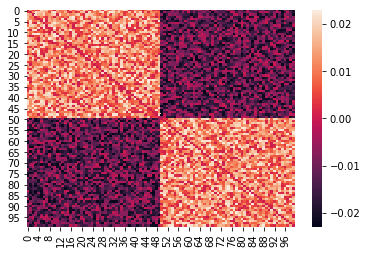

In [3]:
N_neurons = 100
weights = create_weights_binary_network(N=N_neurons, phigh=2.3, ilow=-2.3)/N_neurons
sns.heatmap(weights)

<AxesSubplot:>

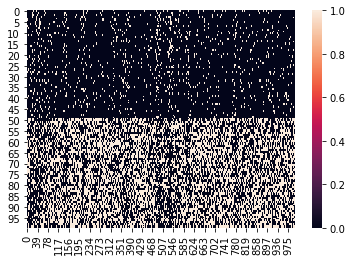

In [4]:
Tmax = 1000
n_batches = 16
spikes = np.zeros(shape=(N_neurons,Tmax, n_batches))
idx = torch.randperm(N_neurons)
for i in range(n_batches):
    spikes[:, 0, i] = np.random.choice([0,1],size=(N_neurons))

    for t in range(1,Tmax):
        spikes[:, t, i] = np.random.random(N_neurons) < (spikes[:,t-1, i]@weights + np.random.uniform(0,0.5,size=N_neurons))
        spikes[idx, t, i]
spikes = torch.tensor(spikes)
sns.heatmap(spikes[:,:,2])

### Train cRTRBM
Sparsity is only enforced on VH

In [5]:
n_epochs = 100
N_H = 8
crtrbm = RTRBM(spikes, N_H = N_H)
N_V = N_neurons

errors_epoch = torch.zeros(n_epochs)
HH_epoch = torch.zeros(N_H, N_H, n_epochs)
VH_epoch = torch.zeros(N_V, N_H, n_epochs)

lr = torch.linspace(1e-2, 1e-5, n_epochs)

for i in tqdm(range(n_epochs)):
    crtrbm.learn(
              spars_penalty=3e-4, x=2, sp=True,
              activationFunction=torch.sigmoid,
              learning_rate=lr[i], learning_rate_decay=False,
              momentum=0.85,
              weightcost=0.0002,
              CDk=10,
              n_epochs=1,
              batchsize=16,
              disable_tqdm=True)
    
    errors_epoch[i] = crtrbm.errors
    VH_epoch[:, :, i] = crtrbm.W.T
    HH_epoch[:, :, i] = crtrbm.W_acc

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.47it/s]


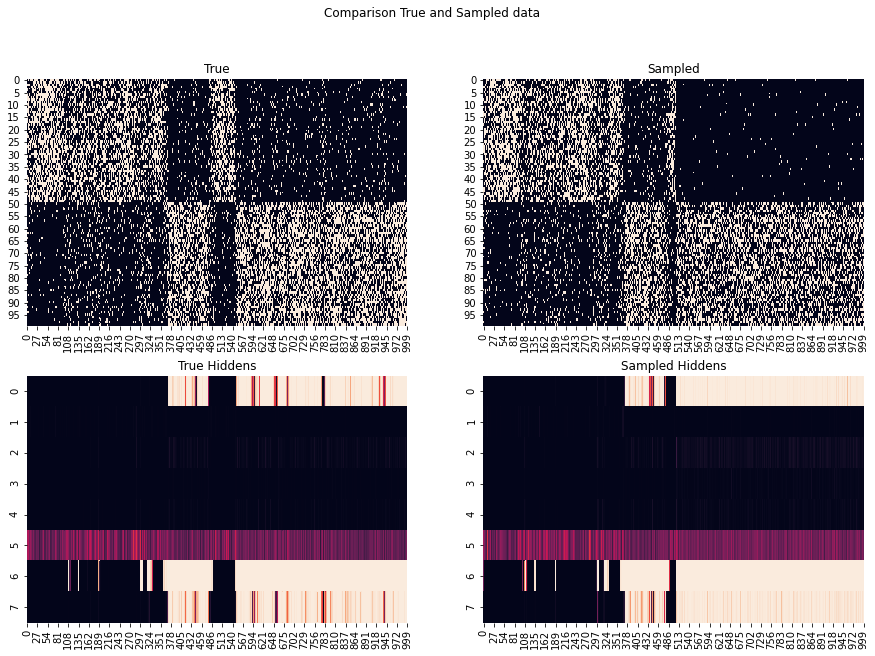

In [17]:
sample = 3
vt_sampled, rt_sampled = crtrbm.infer(spikes[:,:Tmax//2, sample],
                                        pre_gibbs_k=1000,
                                        gibbs_k=100,
                                        mode=3,
                                        t_extra=0)

plot_true_sampled(spikes[:,:,sample], crtrbm.visible_to_hidden(spikes[:,:,sample].float()), vt_sampled, rt_sampled)

### Weight distributions and evolution per epoch

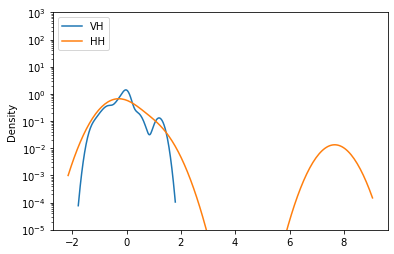

In [7]:
plot_weights_log_distribution_compare(crtrbm.W, crtrbm.W_acc, label1='VH', label2='HH', ymin=10e-6, ymax=1000)

Sparcity:	 0.39375001192092896
Sparcity:	 0.171875


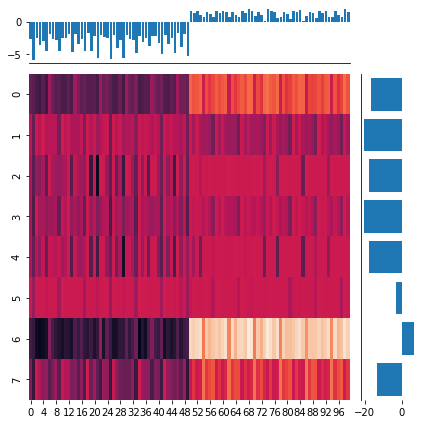

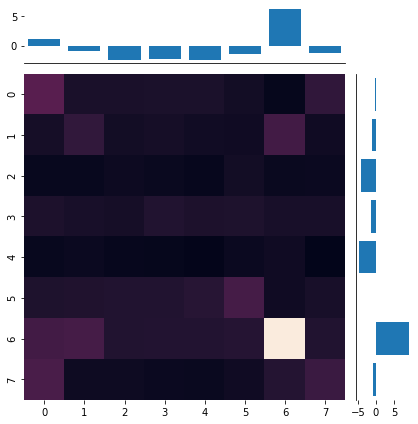

In [8]:
plot_weights_heatmap_sum(crtrbm.W, print_sparsity = True, th = 0.1)
plot_weights_heatmap_sum(crtrbm.W_acc, print_sparsity = True, th = 0.1)

### Pairwise interaction

Just the matrix product with itself -> Almost all the information that the machine has learned is contained in the weights VH and HH (+ biases, but biases are mostly small against the weigths (<- STILL NEEDS TO BE VERIFIED)). Information in the visible layer is stored in a combination of W that is invariant under transformation of the hidden layer. The most simplest combination is just the product with itself -> $WW^T \rightarrow [(V ,H) * (H, V)]$.  The matrix product reflects correlations of the input configurations (v_train) used for the training of the machine.

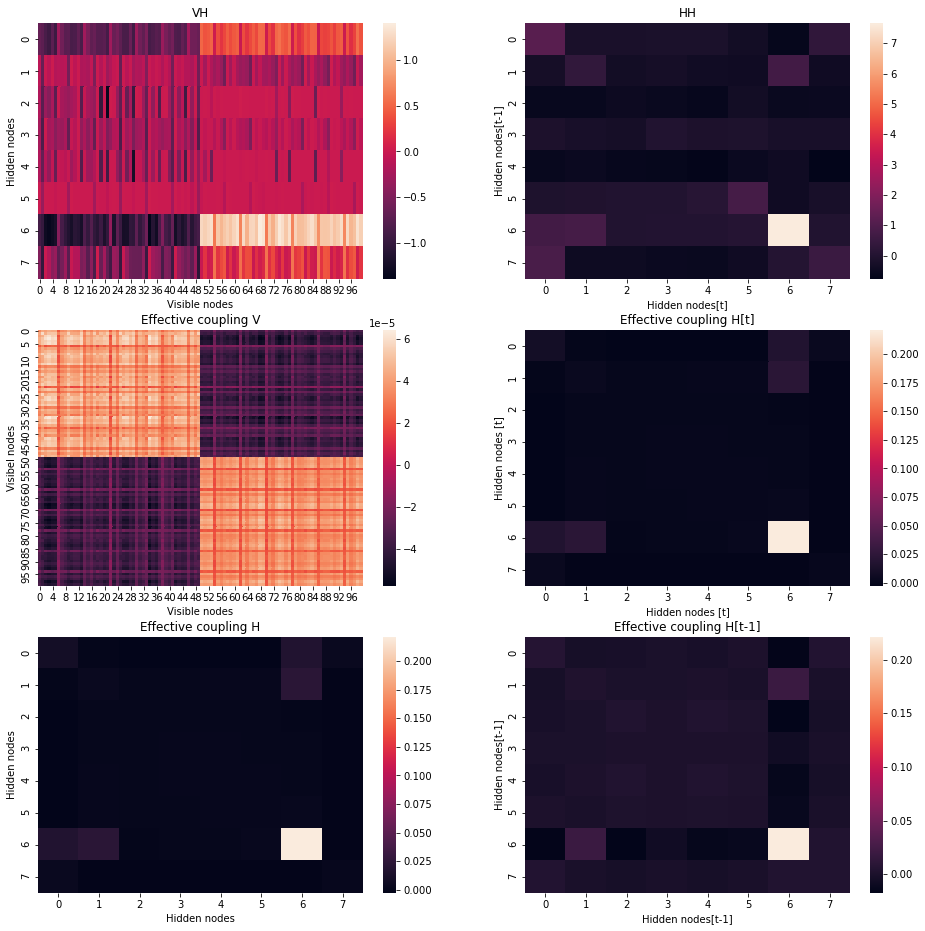

In [9]:
%matplotlib inline
plot_effective_coupling_VH_HH(crtrbm, spikes[:,:, sample].float())

Effective coupling $V_{vh}(t)$ $\rightarrow$ shows similarities with the real coupling matrix we define at the begin of this notebook. 

Find a method to map out the coupling of H[t-1] and V[t] or V[t-1] and V[t] to discover the temporal structure.

In [10]:

#threshold_range = np.linspace(0.01, 3, 300)
#K = np.zeros(threshold_range.shape[0])
#
#for i in range(threshold_range.shape[0]):
#    w = crtrbm.W
#    w[torch.abs(W) < threshold_range[i]] = 0
#    K[i] = np.count_nonzero(w)
#plt.plot(K)


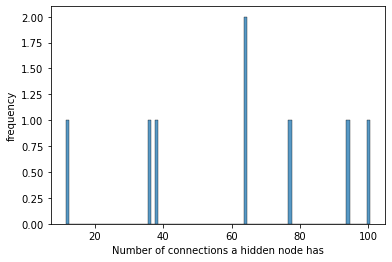

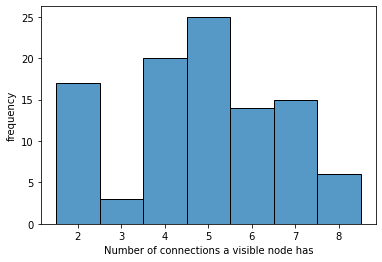

In [11]:
threshold = 0.1
w = crtrbm.W
w[torch.abs(w) < threshold] = 0

n_connection_H = np.zeros(N_H)
for i in range(N_H):
    n_connection_H[i] = np.count_nonzero(w[i,:])
    
n_connection_V = np.zeros(N_V)
for i in range(N_V):
    n_connection_V[i] = np.count_nonzero(w[:,i])
    
sns.histplot(n_connection_H, binwidth=1, discrete=True)
plt.xlabel("Number of connections a hidden node has")
plt.ylabel("frequency")
plt.show()
sns.histplot(n_connection_V, binwidth=1, discrete=True)
plt.xlabel("Number of connections a visible node has")
plt.ylabel("frequency")
plt.show()

The graph show be interperted that you have y (frequency) visibles that have x (number of connection a visible node has) connections. Same as for the hiddens.

## Bipartite graph

<AxesSubplot:>

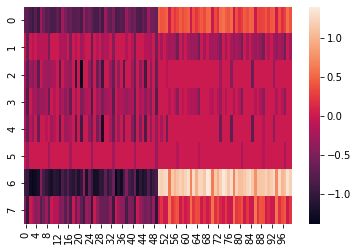

In [12]:
#w[w!=0] = 1
sns.heatmap(w)


### Closeness centrality

The closeness of a node is the distance to all other nodes in the graph normalized by the minimum distance possible. Where the distance is determined on how many edges you need to walk on to get to another node, where we count one edge as 1.

In [13]:
# pip install networkx

import networkx as nx
from networkx.algorithms import bipartite
from scipy import sparse

# define scipy sparse matrix (=np.array, but in another format)
ws = sparse.csr_matrix(w)

# define graph in bipartite graph (RBM)
G = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(ws)

# Check if G is connected via a bipartite graph
print(nx.is_connected(G))

# define the two node sets
bottom_nodes, top_nodes = bipartite.sets(G)

# Note the indexing, bottom_nodes = hiddens, top_nodes = visibles
print(list(bottom_nodes),list(top_nodes))

True
[0, 1, 2, 3, 4, 5, 6, 7] [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]


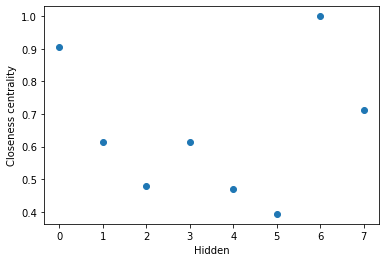

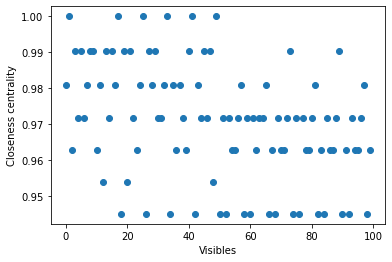

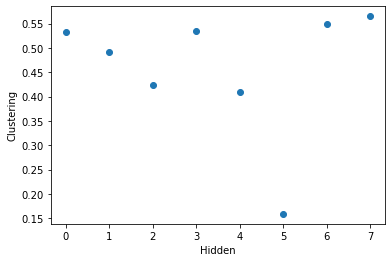

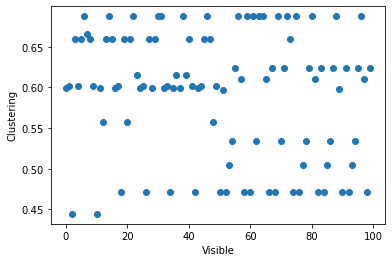

In [14]:
# calculate closeness centrality
closeness_centrality = nx.algorithms.bipartite.centrality.closeness_centrality(G, bottom_nodes)
clustering = nx.algorithms.bipartite.clustering(G)

Cl_Ce_H = torch.zeros(N_H)
Cl_Ce_V = torch.zeros(N_V)
Cl_H = torch.zeros(N_H)
Cl_V = torch.zeros(N_V)

for i in range(N_H):
    Cl_Ce_H[i] = closeness_centrality[i]
    Cl_H[i] = clustering[i]
for i in range(N_V):
    Cl_Ce_V[i] = closeness_centrality[N_H + i]
    Cl_V[i] = clustering[N_H + i]
    
plt.plot(Cl_Ce_H, 'o')
plt.xlabel("Hidden")
plt.ylabel("Closeness centrality")
plt.show()

plt.plot(Cl_Ce_V, 'o')
plt.xlabel("Visibles")
plt.ylabel("Closeness centrality")
plt.show()

plt.plot(Cl_H, 'o')
plt.xlabel("Hidden")
plt.ylabel("Clustering")
plt.show()

plt.plot(Cl_V, 'o')
plt.xlabel("Visible")
plt.ylabel("Clustering")
plt.show()

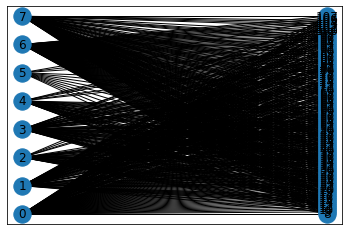

In [15]:
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, bottom_nodes))

In [16]:
mean_path_length_vv = torch.zeros(N_V)

for j in tqdm(range(N_V)):
    tot_path_length = 0
    for i in range(N_V+N_H):
        num = len(nx.shortest_path(G)[N_H + j][i])
        if num == 1:
            continue
        elif num % 2 == 0:
            continue
        else:
            # num is the number of nodes, num-1 is the number of edges
            tot_path_length += (num-1)
    mean_path_length_vv[j] = int(tot_path_length / (N_V-1))
torch.mean(mean_path_length_vv)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.11s/it]


tensor(2.)